In [1]:
# if you are using google colab then please exectue the below 1st
# from google.colab import files
# files.upload()

In [2]:
# !unzip -q hacklive2_dataset_complete.zip

In [3]:
!pip install -q --upgrade seaborn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [5]:
train = pd.read_csv('train_dPrl03o.csv')
test = pd.read_csv('test_mPTIhGU.csv')

Lets go and explore our training and test datasets. We will do the following steps:

1. Brief Look at the Dataset
2. See the dataset shape.
3. Target Distribution.
4. See the variables datatypes.
5. See the number of missing/null values.
6. See the number of unique values in each variable. 

In [6]:
train.head(3)
test.head(3)

video_id                                              title  \
0     53364  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...   
1     51040  It's Showtime Miss Q & A: Bela gets jealous of...   
2      1856  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n  ಕ್...   

           channel_title  category_id publish_date  \
0                 HUM TV         24.0   2017-12-12   
1  ABS-CBN Entertainment         24.0   2018-03-08   
2     SANDALWOOD REVIEWS         24.0   2018-03-26   

                                                tags     views  dislikes  \
0  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...  351430.0     298.0   
1  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...  461508.0      74.0   
2  challenging star darshan latest news|"challeng...   40205.0     150.0   

   comment_count                                        description  \
0          900.0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...   
1          314.0  Vice Ganda notices Bela Padilla's sudden chang...   
2          100.0  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ    ಕ್ಲ...   

  country_code   likes  
0           CA  2351.0  
1           CA  3264.0  
2           IN   580.0

video_id                                              title  \
0     87185  జనవరి 31 గ్రహణం రోజు కొడుకులు ఉన్నవాళ్లు ఏం చే...   
1      9431  ठाणे:'जेव्हा सत्ता बदलेल तेव्हा केस तुमच्यावरह...   
2     40599                           Thank you, Rider Nation!   

              channel_title  category_id publish_date  \
0     CHIRRAVURI FOUNDATION         22.0   2018-01-17   
1           VIRAL IN  INDIA         22.0   2017-11-18   
2  Saskatchewan Roughriders         17.0   2017-12-01   

                                                tags     views  dislikes  \
0  Chirravuri|"Foundation"|"chirravuri foundation...   80793.0      54.0   
1  Raj Thackeray|"LIVE SPEECH"|"latest Speech"|"r...  150317.0     230.0   
2  Roughriders|"Riders"|"CFL"|"Regina"|"Saskatche...    6558.0      10.0   

   comment_count                                        description  \
0           79.0  8885569579...CHIRRAVURI FOUNDATION.\n\n☛Subsct...   
1          311.0  Don't Forget to SUBSCIRBE to our YouTube Chann...   
2            7.0  “To the devoted, the impassioned, the loyal:\n...   

  country_code  
0           IN  
1           IN  
2           CA

In [7]:
ID_COL, TARGET_COL = 'video_id', 'likes'

In [8]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 26061 samples and 12 variables

Test contains 11170 samples and 11 variables

The dataset contains 10 features


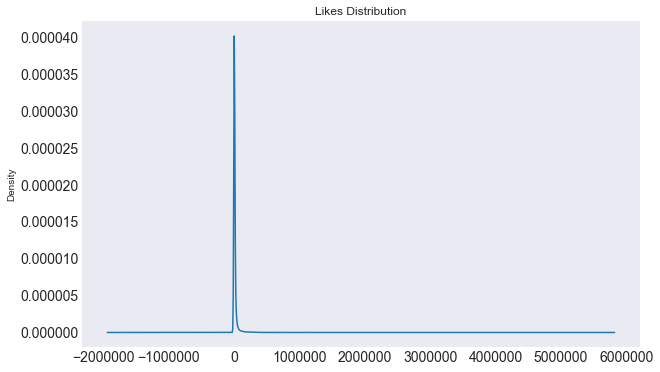

In [10]:
_ = train[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=14, figsize=(10, 6))

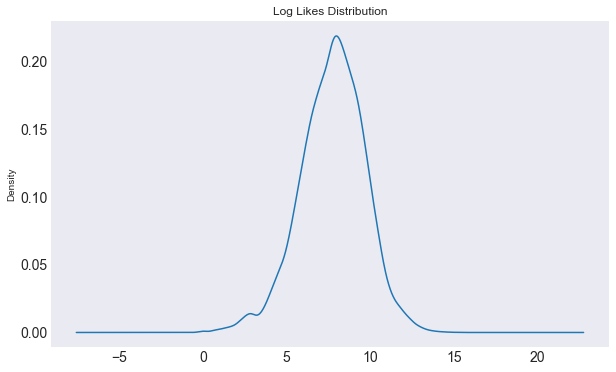

In [11]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

Let's the see the same for boxplot.

1. Without log-transformation.
2. With log-transformation.

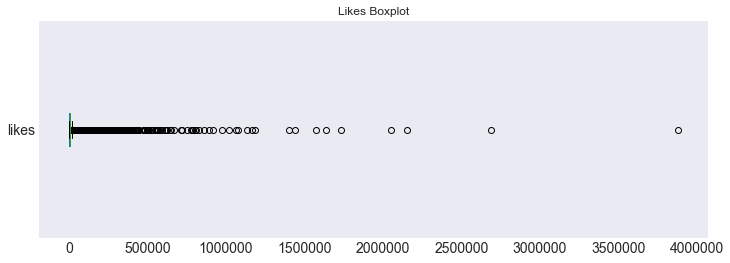

In [13]:
_ = train[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

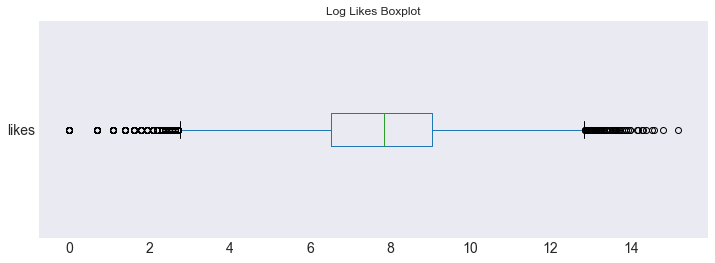

In [14]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'box',
                                                vert=False,
                                                figsize=(12, 4),
                                                title = 'Log Likes Boxplot',
                                                fontsize=14)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
video_id         26061 non-null int64
title            26061 non-null object
channel_title    26061 non-null object
category_id      26061 non-null float64
publish_date     26061 non-null object
tags             26061 non-null object
views            26061 non-null float64
dislikes         26061 non-null float64
comment_count    26061 non-null float64
description      26061 non-null object
country_code     26061 non-null object
likes            26061 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


Looks like we have a mixture of datatypes, a lot of these variables are object datatypes. Object datatypes are used to store strings along with other non-numeric data. This is obvious since we encountered a lot of strings when we had a look at the dataset.

Machine Learning Models understand only numbers so we will have to later convert these strings to numbers

In [16]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

likes            0.0
country_code     0.0
description      0.0
comment_count    0.0
dislikes         0.0
views            0.0
tags             0.0
publish_date     0.0
category_id      0.0
channel_title    0.0
title            0.0
video_id         0.0
dtype: float64

In [17]:
train.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

There are 4 types of features that we have:

1. Numerical
2. Categorical
3. Textual
4. DateTime


Also our target is Continuous

For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time

2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'likes'




In [18]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

In [19]:
num_cols = ['views', 'dislikes', 'comment_count']

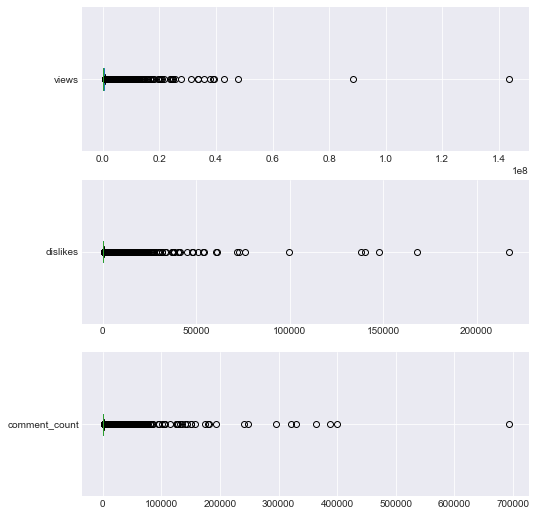

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

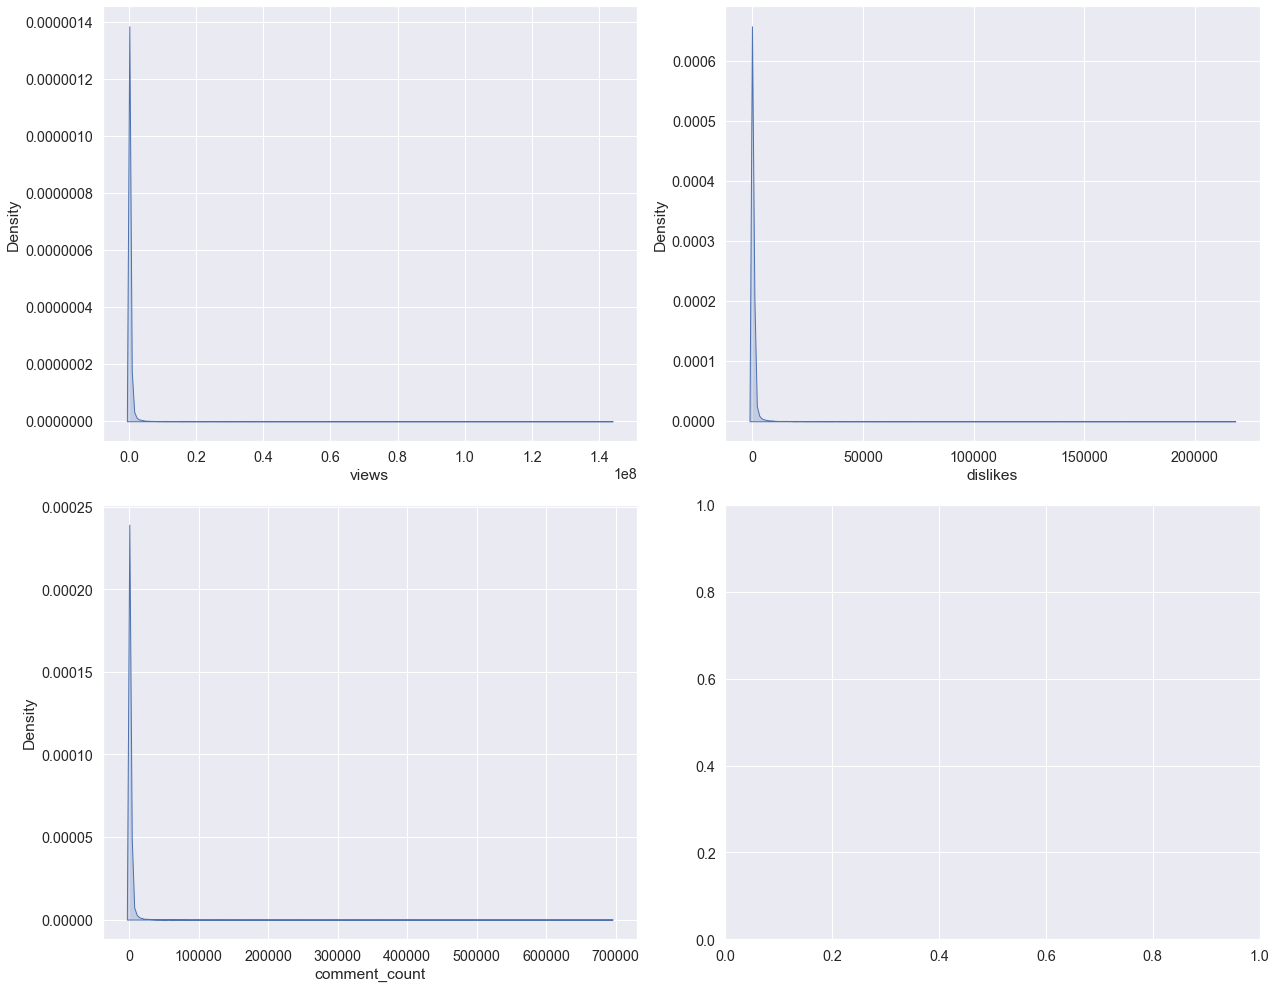

In [28]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

In [29]:
for c in num_cols + ['likes']:
  train[c] = np.log1p(train[c]) 

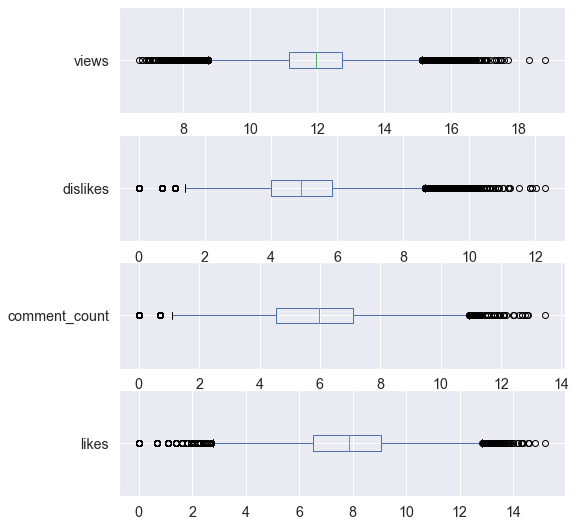

In [30]:
fig, axes = plt.subplots(4, 1, figsize=(8, 9))
for i, c in enumerate(num_cols + ['likes']):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

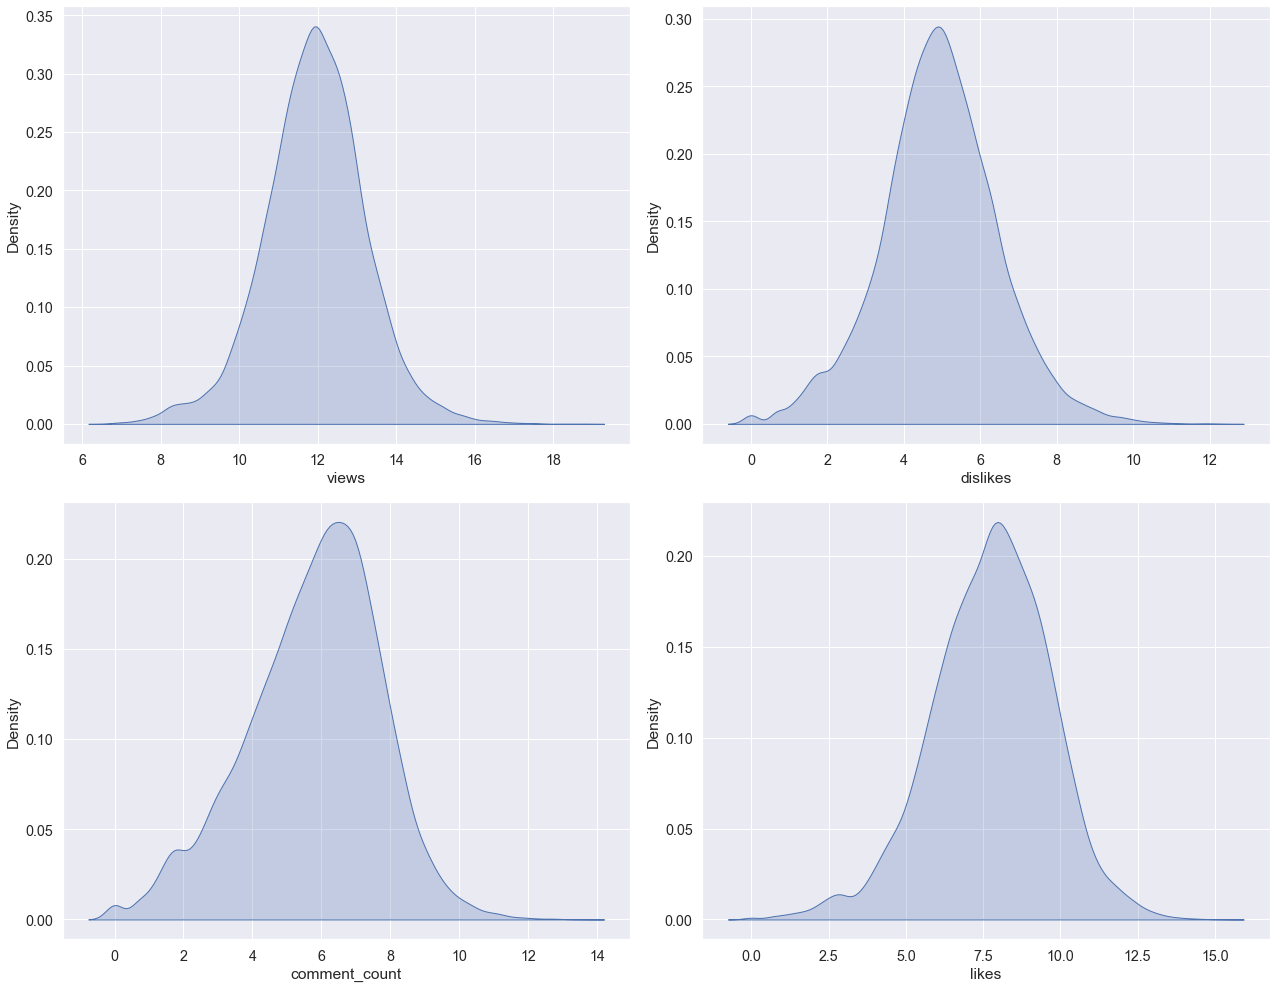

In [32]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols + ['likes']):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

Bivariate Analysis

<Figure size 1008x576 with 0 Axes>

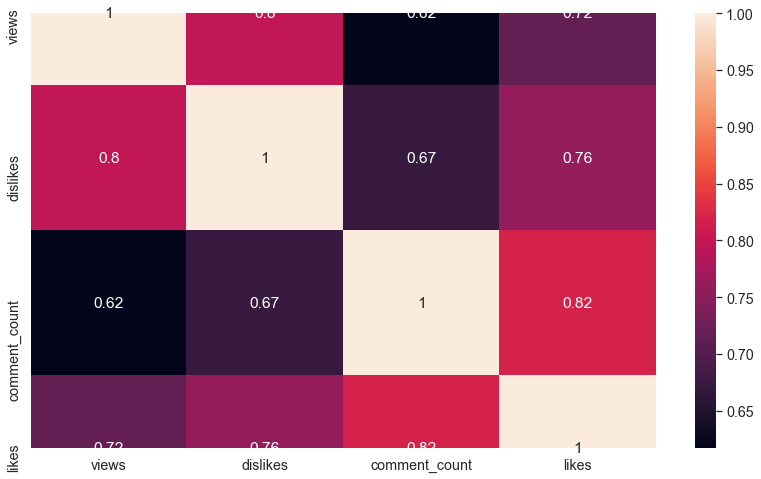

In [33]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols + ['likes']].corr(), annot=True)

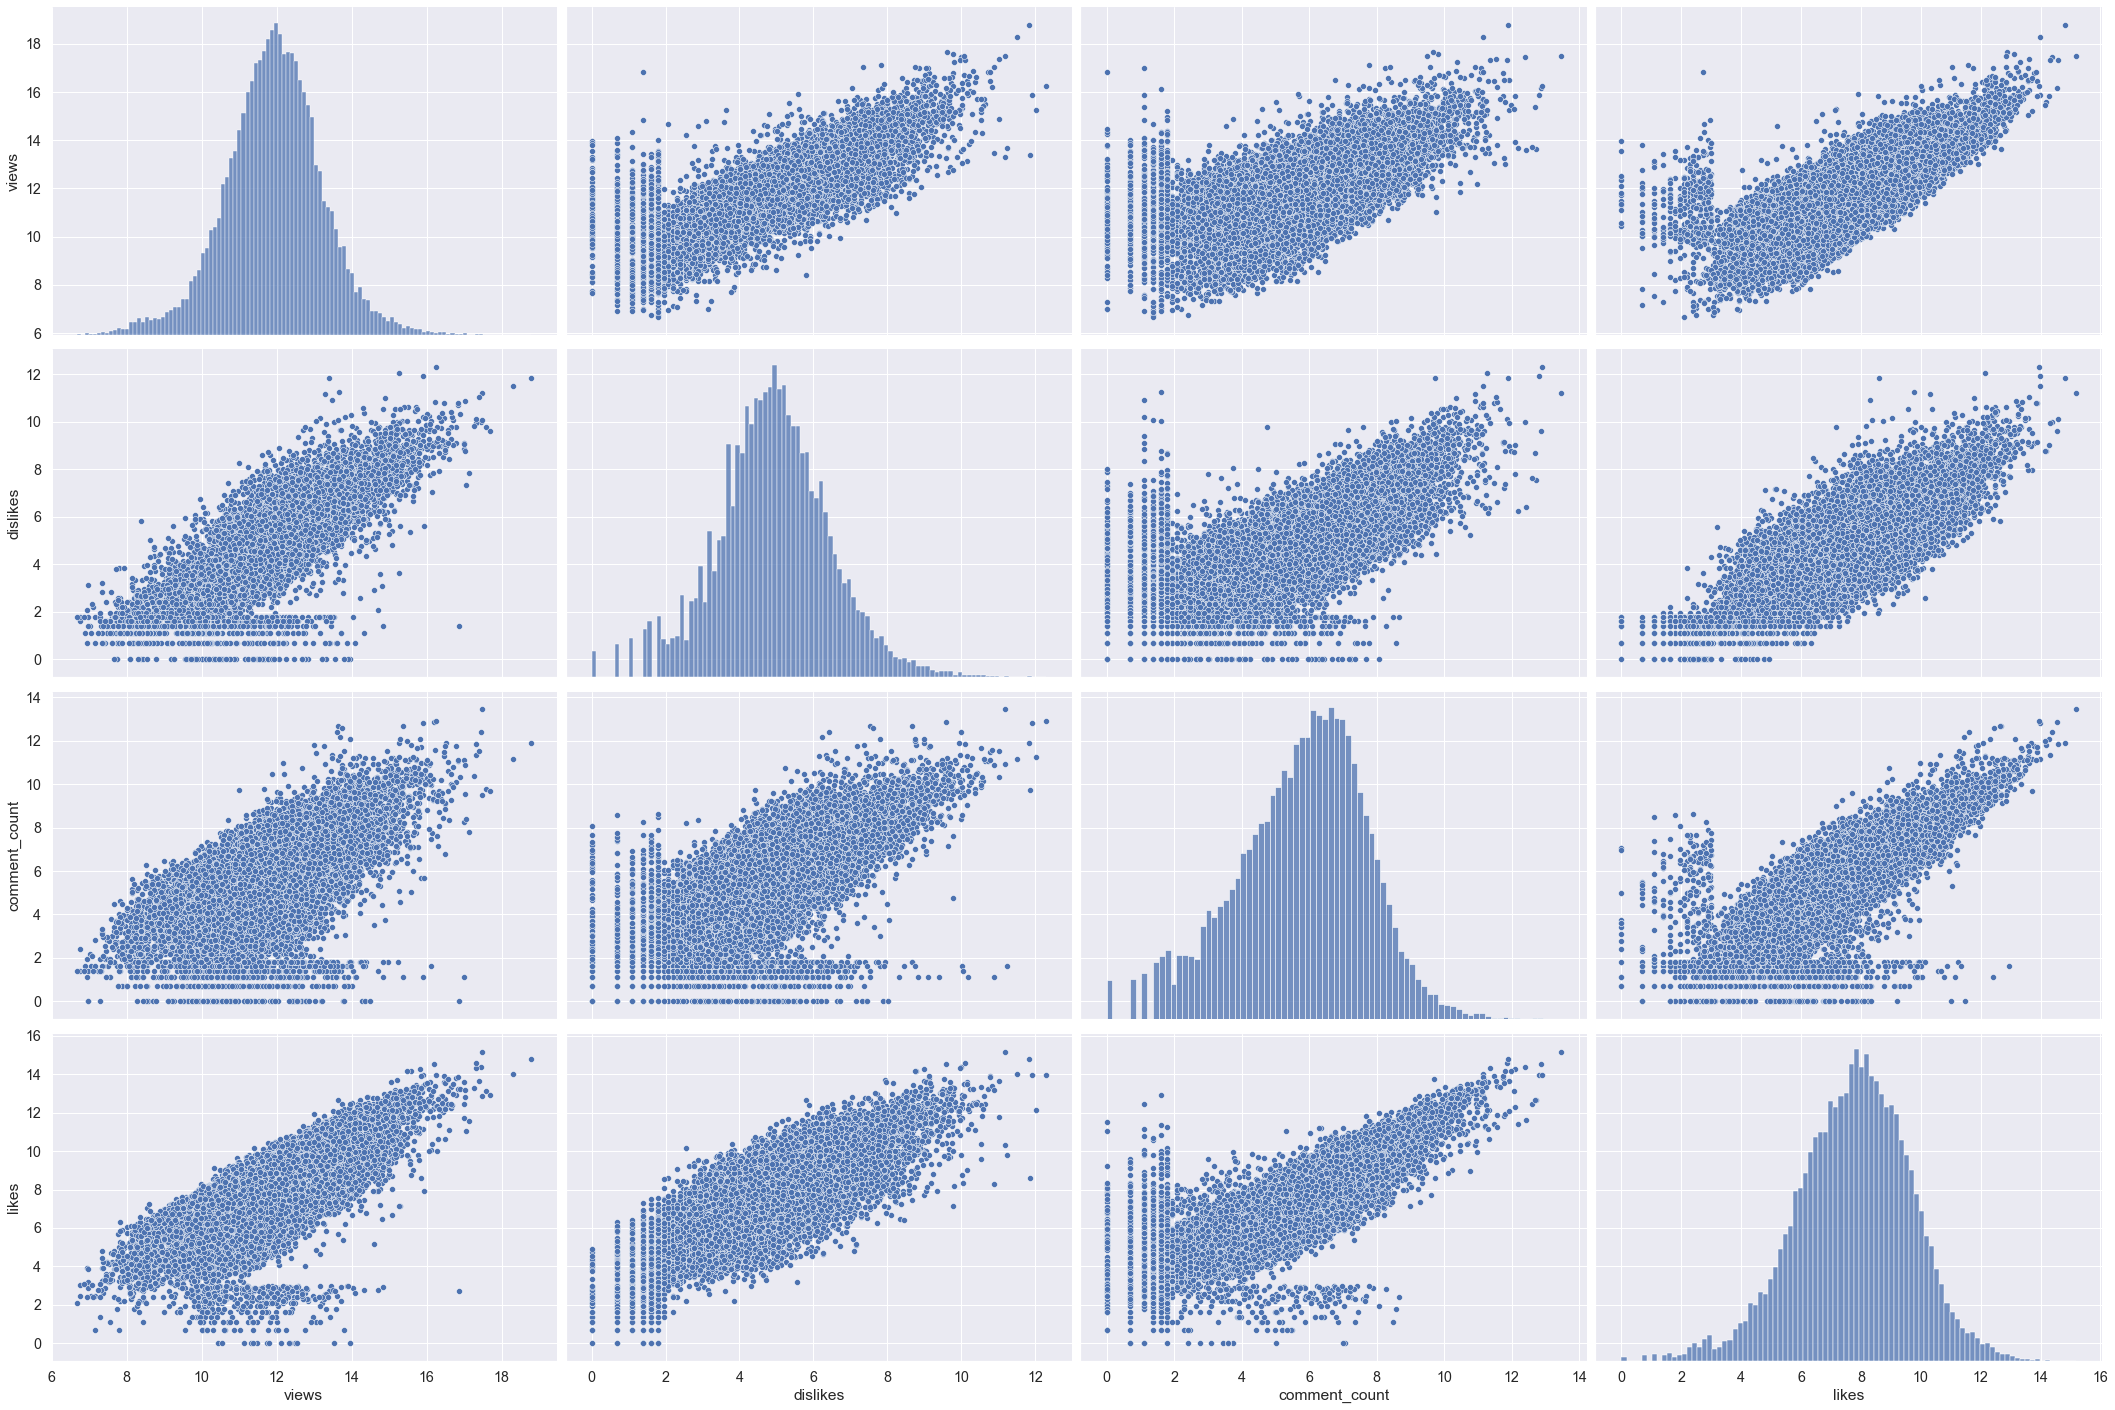

In [34]:
_ = sns.pairplot(train[num_cols + ['likes']], height=5, aspect=24/16)

Categorical Variables

In [35]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
video_id         26061 non-null int64
title            26061 non-null object
channel_title    26061 non-null object
category_id      26061 non-null float64
publish_date     26061 non-null object
tags             26061 non-null object
views            26061 non-null float64
dislikes         26061 non-null float64
comment_count    26061 non-null float64
description      26061 non-null object
country_code     26061 non-null object
likes            26061 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


In [38]:
train['channel_title'].nunique()

5764

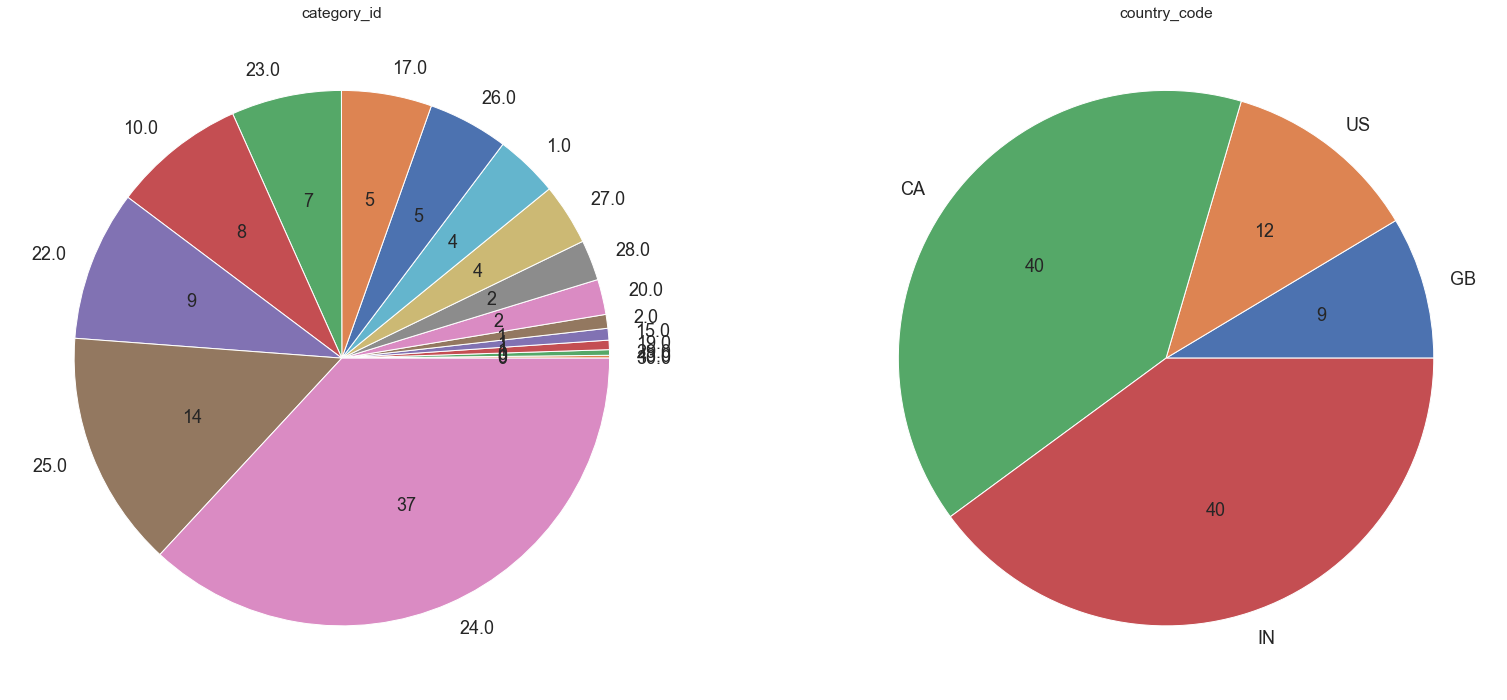

In [39]:
cat_cols = ['category_id', 'country_code', 'channel_title']
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for i, c in enumerate(['category_id', 'country_code']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

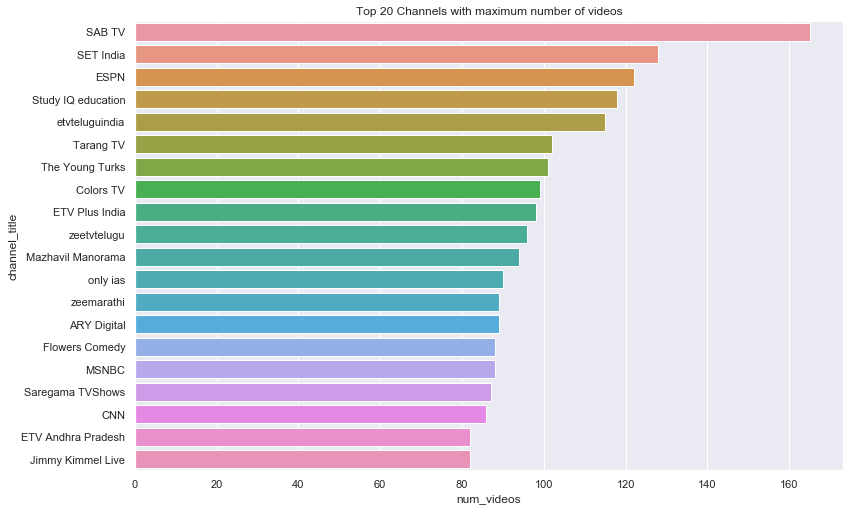

In [40]:
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels = train['channel_title'].value_counts()[:20].reset_index()
top_20_channels.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

Bivariate Analysis

In [44]:
country_wise_channels = train.groupby(['country_code', 'channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)
print(country_wise_channels)

     country_code       channel_title  num_videos
4937           IN  Study IQ education         118
5237           IN      etvteluguindia         115
5016           IN           Tarang TV         102
2220           CA     The Young Turks         100
4254           IN           Colors TV          99
...           ...                 ...         ...
2890           GB        All Time Low           1
2889           GB       Alissa Ashley           1
2888           GB               Ali-A           1
2886           GB              Alesso           1
6674           US                 郭韋辰           1

[6675 rows x 3 columns]


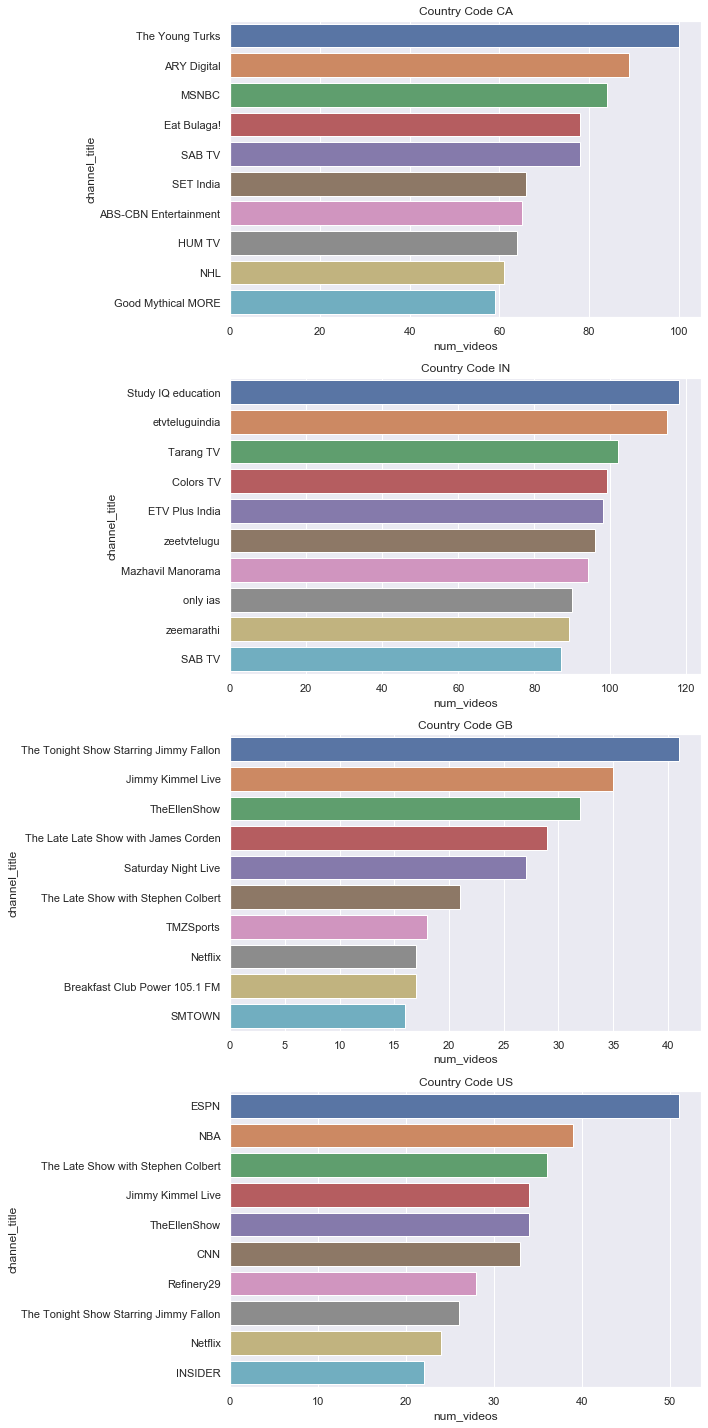

In [47]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'num_videos', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

Multivariate Analysis

In [49]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)
print(country_wise_channels)

     country_code         channel_title      likes
3994           GB               ibighit  15.171369
3425           GB         LuisFonsiVEVO  14.803627
3106           GB             DrakeVEVO  14.581986
3465           GB  Marvel Entertainment  14.367048
3122           GB            Ed Sheeran  14.306619
...           ...                   ...        ...
4530           IN            Life Hacks   0.693147
1846           CA        ST Productions   0.693147
4734           IN          Pal Pal News   0.693147
6214           US          Rob Andretti   0.693147
2863           GB   5 Seconds of Summer   0.000000

[6675 rows x 3 columns]


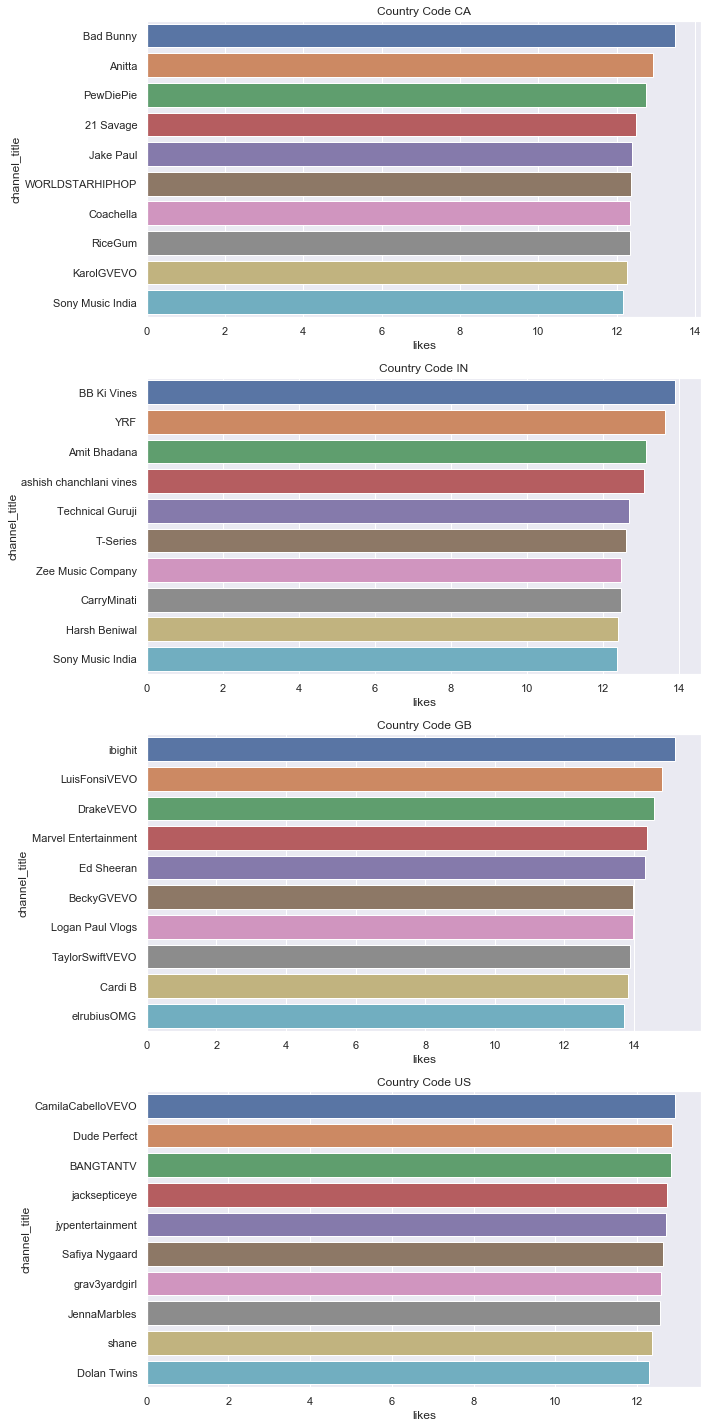

In [50]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'likes', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

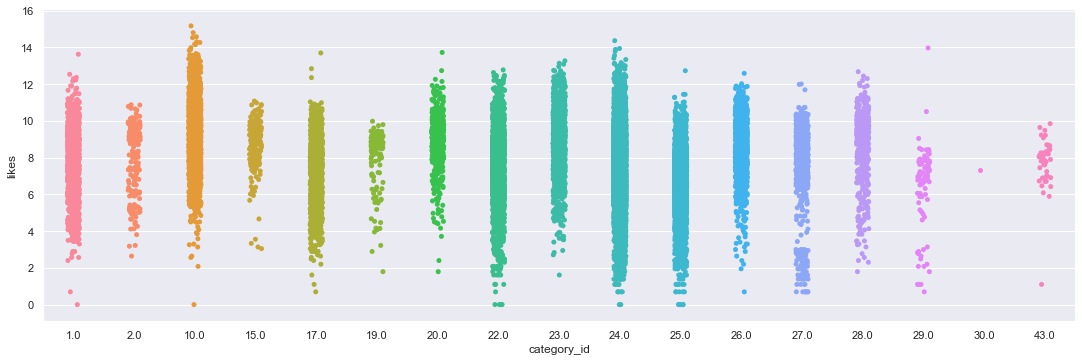

In [51]:
_ = sns.catplot(x="category_id", y="likes", data=train, height=5, aspect=24/8)

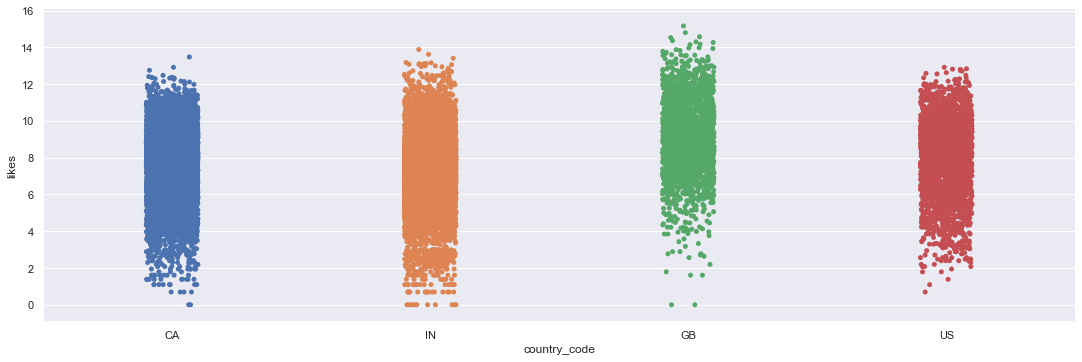

In [52]:
_ = sns.catplot(x="country_code", y="likes", data=train, height=5, aspect=24/8)

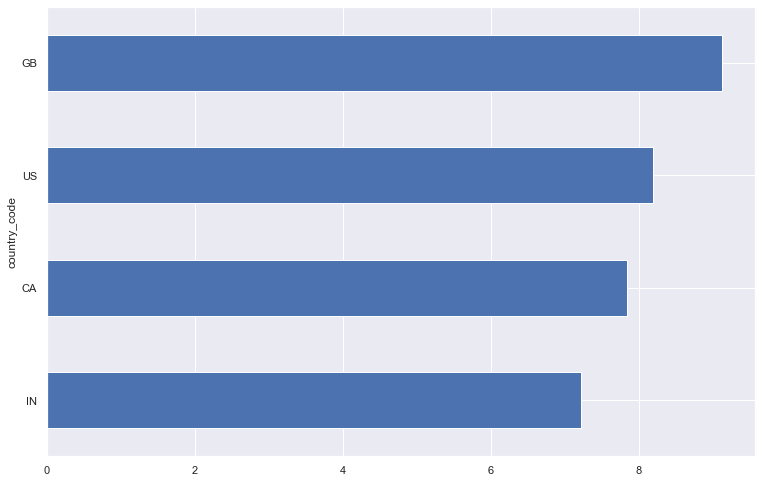

In [53]:
# Mean likes per country
_ = train.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh')

Date time Variable

In [54]:
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
train['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
26056   2018-01-16
26057   2017-12-17
26058   2018-03-04
26059   2018-05-17
26060   2018-01-16
Name: publish_date, Length: 26061, dtype: datetime64[ns]

In [55]:
train['publish_date'].min(), train['publish_date'].max()

(Timestamp('2006-07-23 00:00:00'), Timestamp('2018-06-14 00:00:00'))

In [58]:
train['publish_date'].dt.year.value_counts()

2018    18841
2017     7132
2015       16
2016       16
2011       13
2014        9
2013        9
2009        8
2012        6
2010        4
2008        3
2007        3
2006        1
Name: publish_date, dtype: int64

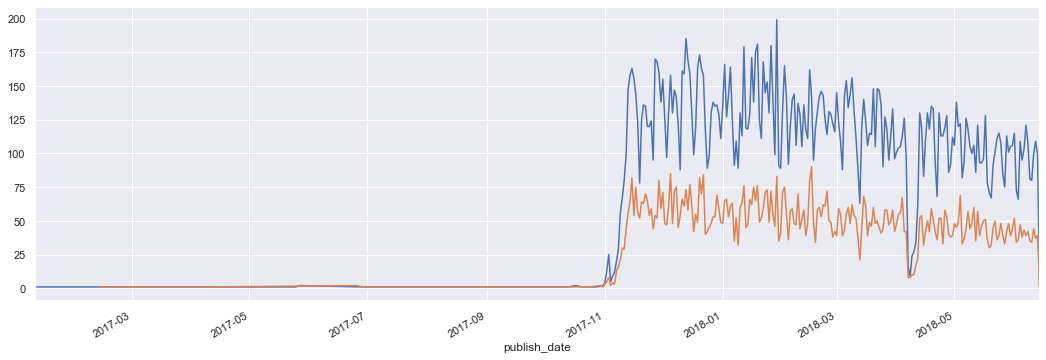

In [62]:
latest_data_train = train[train['publish_date'] > '2017']
latest_data_test = test[test['publish_date'] > '2017']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))

In [60]:
test.shape, train.shape

((11170, 11), (26061, 12))

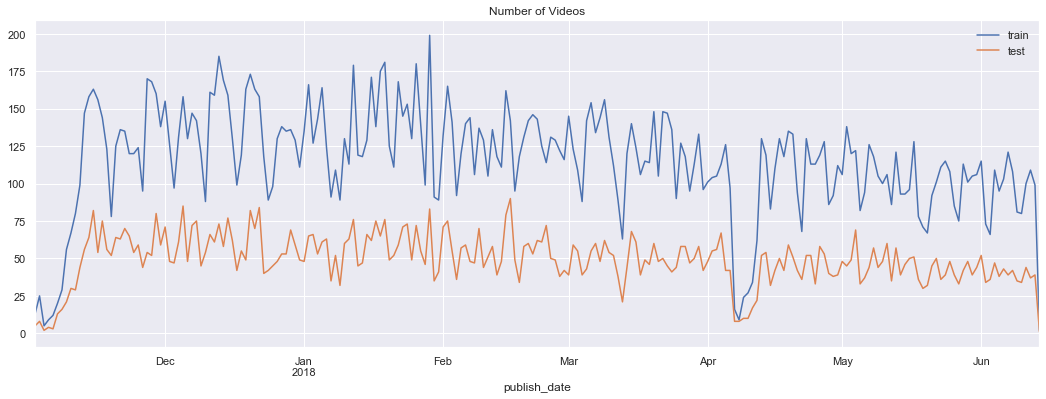

In [63]:
latest_data_train = train[train['publish_date'] > '2017-11']
latest_data_test = test[test['publish_date'] > '2017-11']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(18, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(18, 6), title = 'Number of Videos')
_ = plt.legend()

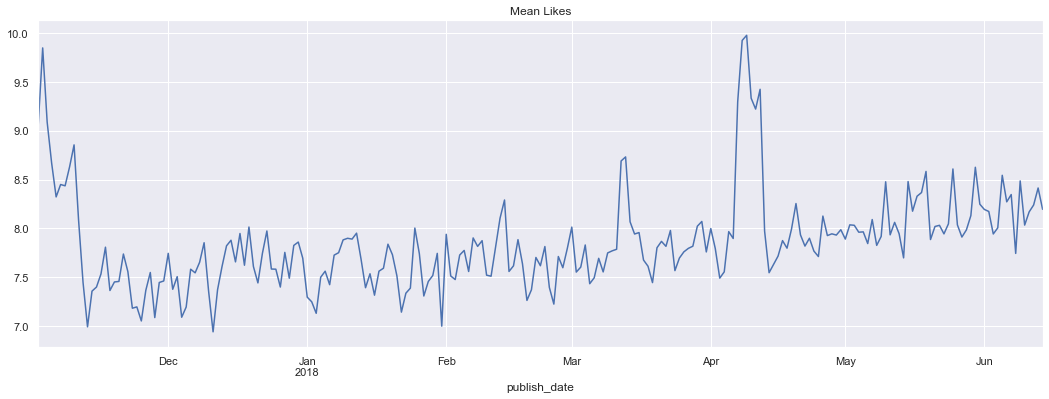

In [64]:
latest_data = train[train['publish_date'] > '2017-11']
_ = latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes")

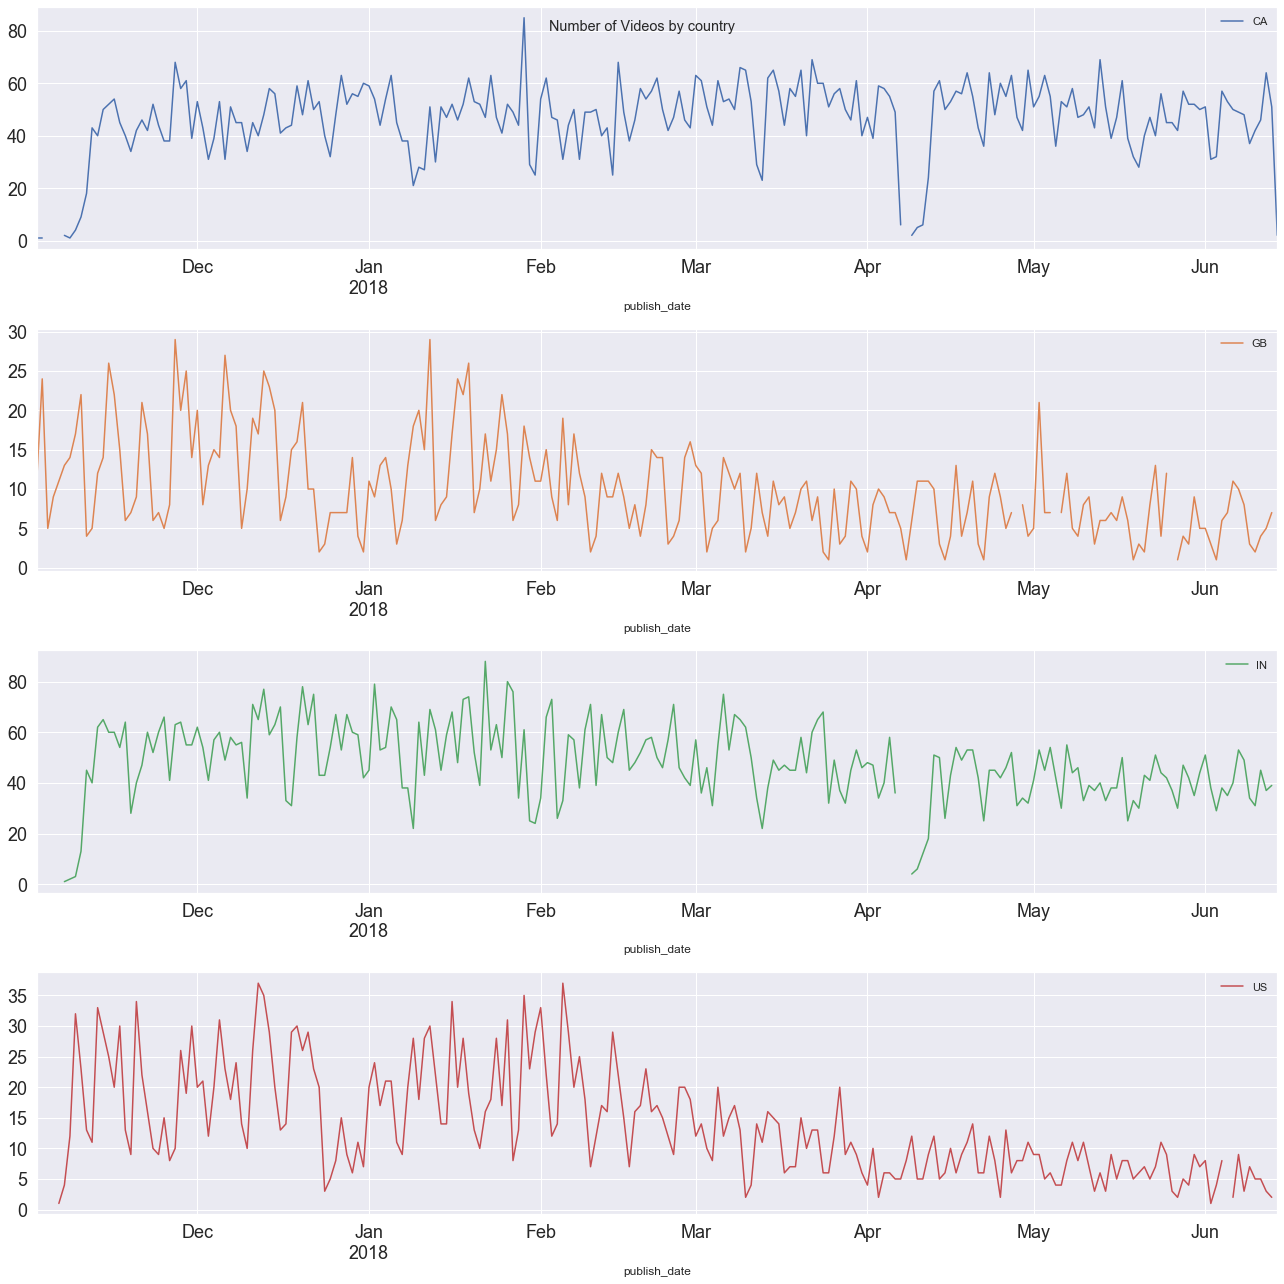

In [65]:
tmp = latest_data.groupby(['publish_date', 'country_code']).size().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, figsize=(18, 18),
                                                                                           title='Number of Videos by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

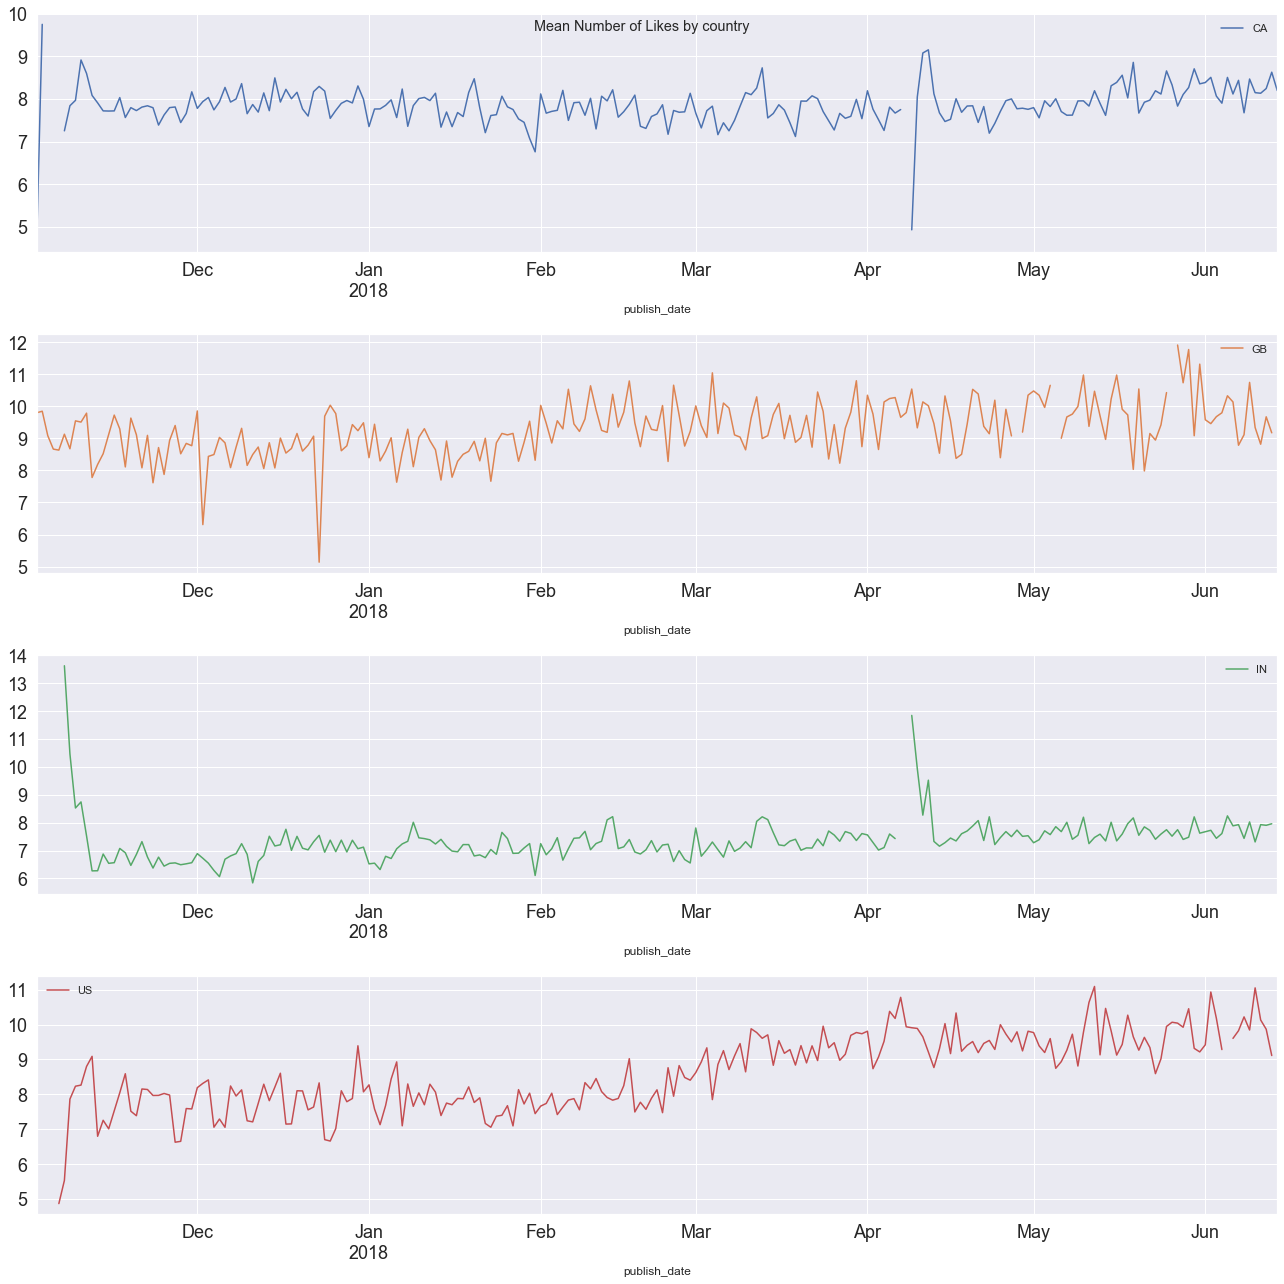

In [66]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(18, 18),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

In [67]:
train['dayofweek'] = train['publish_date'].dt.dayofweek

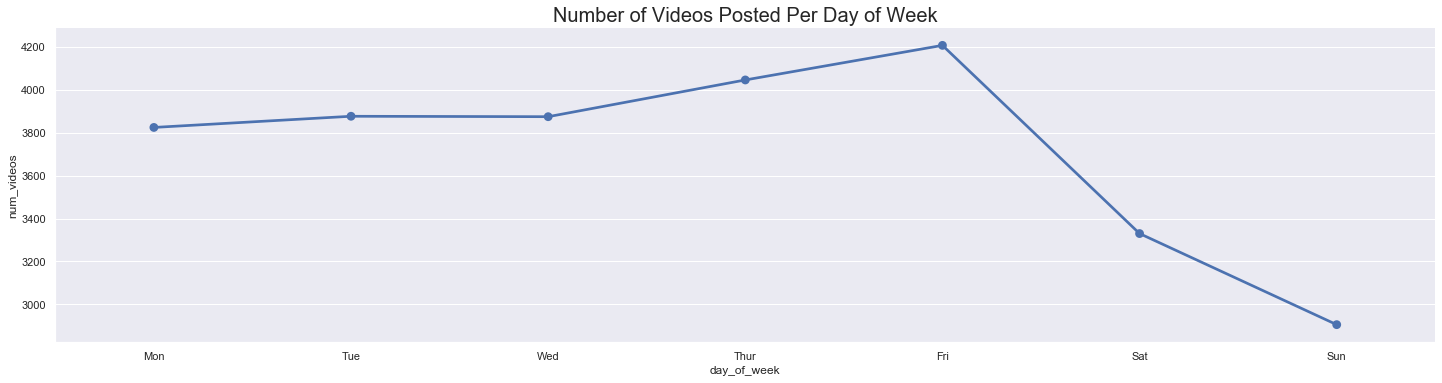

In [68]:
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
_ = sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 24/6)
_ = plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

Textual Data

In [69]:
text_cols = ['title', 'tags', 'description']

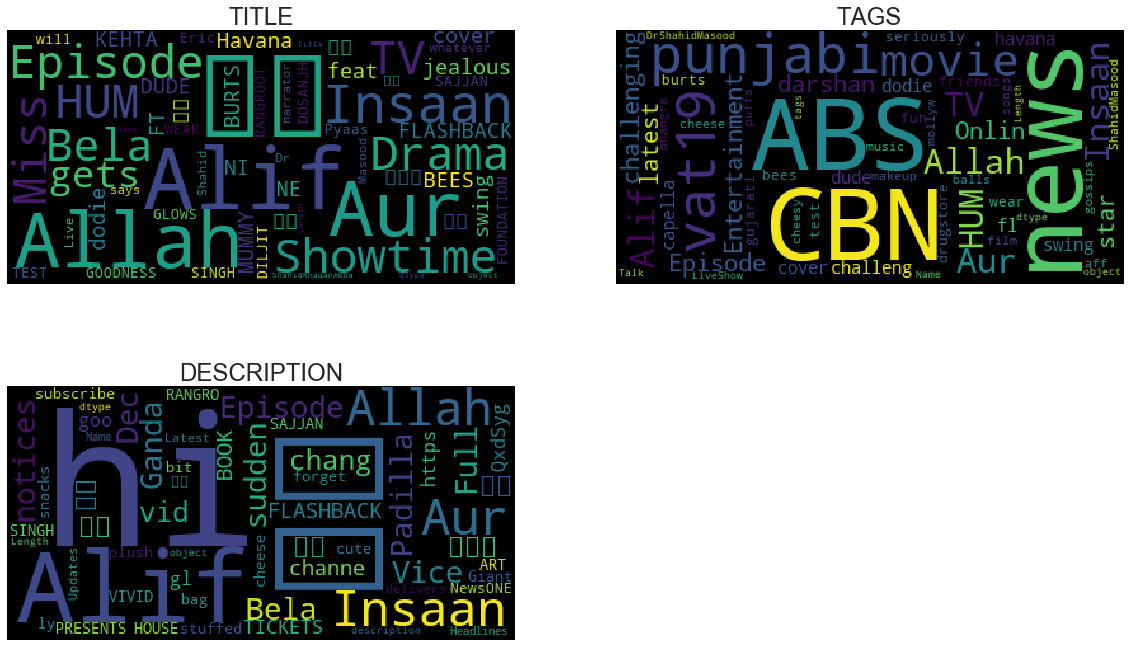

In [71]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
  op = wc.generate(str(train[c]))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(c.upper(), fontsize=24)
  _ = axes[i].axis('off')

_ = fig.delaxes(axes[3])

In [72]:
train['likes'].describe()

count    26061.000000
mean         7.739954
std          1.927899
min          0.000000
25%          6.527958
50%          7.840706
75%          9.054154
max         15.171369
Name: likes, dtype: float64

In [73]:
100 * ((train['likes'] > 10).sum()/train.shape[0])

10.694140669966616

In [74]:
def plot_countrywise(country_code = 'IN'):
  country = train[train['country_code'] == country_code]
  country = country[country['likes'] > 10]
  fig, axes = plt.subplots(2, 2, figsize=(20, 12))
  axes = [ax for axes_row in axes for ax in axes_row]

  for i, c in enumerate(text_cols):
    op = wc.generate(str(country[c]))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(c.upper(), fontsize=24)
    _ = axes[i].axis('off')

  fig.delaxes(axes[3])
  _ = plt.suptitle(f"Country Code: '{country_code}'", fontsize=30)

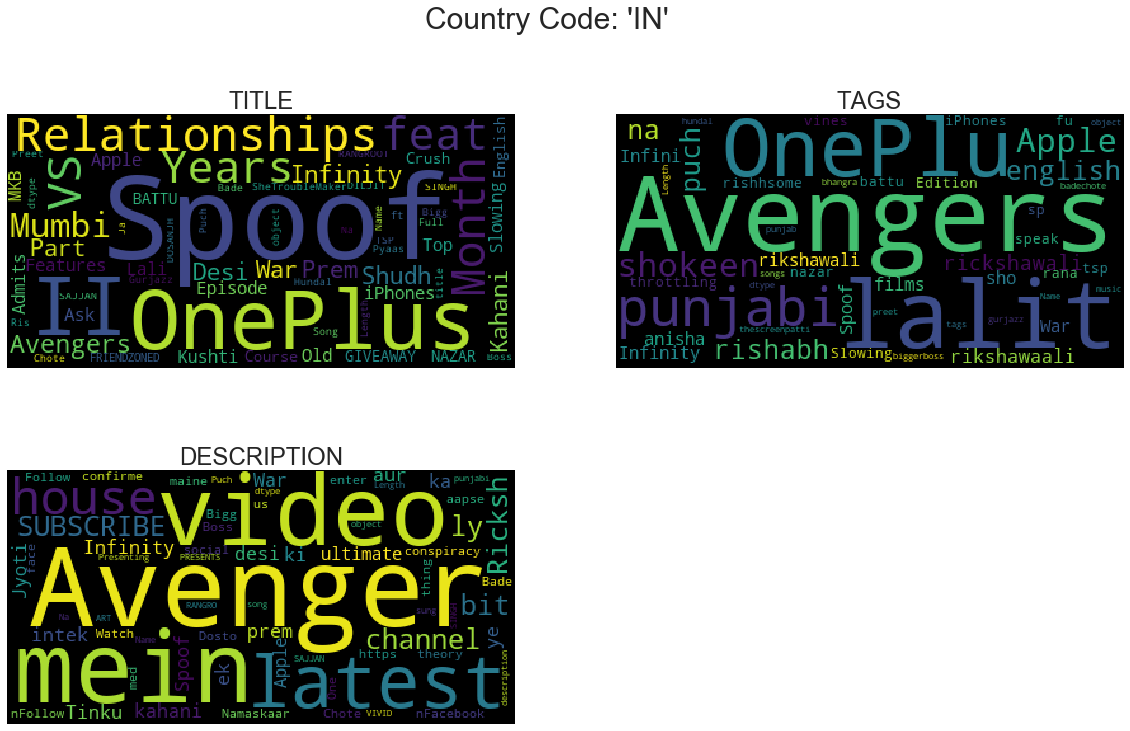

In [75]:
plot_countrywise()

Similarly we can call and display text data for GB, CA and US

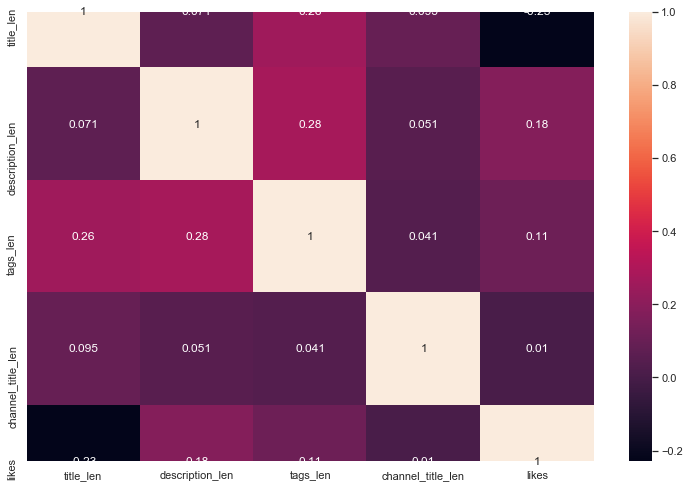

In [76]:
# to check if descriptive video gets more number of likes
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

_  = sns.heatmap(train[['title_len', 'description_len', 'tags_len', 'channel_title_len', 'likes']].corr(), annot = True)

In [77]:
ss=pd.read_csv('sample_submission_cxCGjdN.csv')
ss.head()

video_id  likes
0     87185      0
1      9431      0
2     40599      0
3       494      0
4     73942      0

In [78]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)
    
  ## 3. Downloading and submitting the csv file if using google colab
  # from google.colab import files
  # files.download(file_name)

In [79]:
train = pd.read_csv('train_dPrl03o.csv')
test = pd.read_csv('test_mPTIhGU.csv')

train[num_cols + ['likes']] = train[num_cols + ['likes']].apply(lambda x: np.log1p(x))
test[num_cols] = test[num_cols].apply(lambda x: np.log1p(x))

In [80]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

target = train[TARGET_COL]

Model A. (Predicting all instances as mean)

In [81]:
preds_target = pd.Series([target.mean()] * len(train))

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 1927.8618309979083


In [82]:
preds_test = pd.Series([target.mean()] * len(test))
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_mean_preds.csv')

In [83]:
pd.read_csv('hacklive2_mean_preds.csv').head()

video_id       likes
0     87185  2297.36779
1      9431  2297.36779
2     40599  2297.36779
3       494  2297.36779
4     73942  2297.36779

Model B. For Prediction with Median

preds_target = pd.Series([target.median()] * len(train))
av_metric_score = av_metric(target, preds_target)
print(f'AV metric score is: {av_metric_score}')
preds_test = pd.Series([target.median()] * len(test))
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_median_preds.csv')
**************************************************************************************************************************
Model C. (Predicting using number of views)

likes_per_view = ((train['likes'] + 1)/(train['views'] + 1))
likes_per_view.mean()
preds_target = train['views'] * 0.677
av_metric_score = av_metric(target, preds_target)
print(f'AV metric score is: {av_metric_score}')
preds_test = test['views'] * 0.672
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_preds_using_views.csv')
**************************************************************************************************************************
Model D. (Predicting using number of comments)

likes_per_comment = (train['likes'] + 1)/(train['comment_count'] + 1)
likes_per_comment.mean()
preds_target = train['comment_count'] * 1.37
av_metric_score = av_metric(target, preds_target)
print(f'AV metric score is: {av_metric_score}')
preds_test = test['comment_count'] * 1.37
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_preds_using_num_comments.csv')
**************************************************************************************************************************
Model E. (Predicting using Dislikes)
likes_per_dislike = (train['likes'] + 1)/(train['dislikes']+1)
likes_per_dislike.mean()
preds_target = train['dislikes'] * 1.5
av_metric_score = av_metric(target, preds_target)
print(f'AV metric score is: {av_metric_score}')
preds_test = test['dislikes'] * 1.52
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_preds_using_dislikes.csv')

### **Advance Model Building - Linear Regression** ###

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

!pip install lightgbm
!pip install xgboost
!pip install catboost

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=d68ec605edad5036b37b8fb10a175b6bbc541e8c7c030688ed3a5c028ece5a8a
  Stored in directory: C:\Users\Ketan\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [86]:
train = pd.read_csv('train_dPrl03o.csv')
test = pd.read_csv('test_mPTIhGU.csv')
ss=pd.read_csv('sample_submission_cxCGjdN.csv')

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
video_id         26061 non-null int64
title            26061 non-null object
channel_title    26061 non-null object
category_id      26061 non-null float64
publish_date     26061 non-null object
tags             26061 non-null object
views            26061 non-null float64
dislikes         26061 non-null float64
comment_count    26061 non-null float64
description      26061 non-null object
country_code     26061 non-null object
likes            26061 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


In [88]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

**Steps to Make a Baseline Regression Model**

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a regression Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

In [89]:
train.shape, test.shape

((26061, 12), (11170, 11))

In [90]:
# concatenating row wise
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(37231, 12)

In [91]:
df.head()

category_id          channel_title  comment_count country_code  \
0         24.0                 HUM TV          900.0           CA   
1         24.0  ABS-CBN Entertainment          314.0           CA   
2         24.0     SANDALWOOD REVIEWS          100.0           IN   
3         10.0            doddleoddle         4536.0           GB   
4         23.0         Dude Seriously          161.0           IN   

                                         description  dislikes    likes  \
0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...     298.0   2351.0   
1  Vice Ganda notices Bela Padilla's sudden chang...      74.0   3264.0   
2  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ    ಕ್ಲ...     150.0    580.0   
3  Hi hi hi! here's our vid on FLASHBACK's channe...     847.0  82773.0   
4  BOOK YOUR TICKETS HERE:  https://goo.gl/QxdSyg...      69.0   3557.0   

  publish_date                                               tags  \
0   2017-12-12  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...   
1   2018-03-08  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...   
2   2018-03-26  challenging star darshan latest news|"challeng...   
3   2018-02-21  havana|"cover"|"a capella"|"swing"|"dodie"|"fl...   
4   2018-05-10  dude|"seriously"|"friends"|"fun"|"gujarati"|"h...   

                                               title  video_id     views  
0  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...     53364  351430.0  
1  It's Showtime Miss Q & A: Bela gets jealous of...     51040  461508.0  
2  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n  ಕ್...      1856   40205.0  
3       Havana - swing cover | dodie feat. FLASHBACK     22618  509726.0  
4  MUMMY NE NI KEHTA - 2  FT. 102 NOT OUT| DUDE S...     74074   74311.0

In [92]:
df = pd.get_dummies(df, columns = cat_cols)

In [93]:
df.head(2)

channel_title  comment_count  \
0                 HUM TV          900.0   
1  ABS-CBN Entertainment          314.0   

                                         description  dislikes   likes  \
0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...     298.0  2351.0   
1  Vice Ganda notices Bela Padilla's sudden chang...      74.0  3264.0   

  publish_date                                               tags  \
0   2017-12-12  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...   
1   2018-03-08  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...   

                                               title  video_id     views  ...  \
0  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...     53364  351430.0  ...   
1  It's Showtime Miss Q & A: Bela gets jealous of...     51040  461508.0  ...   

   category_id_26.0  category_id_27.0  category_id_28.0  category_id_29.0  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   

   category_id_30.0  category_id_43.0  country_code_CA  country_code_GB  \
0                 0                 0                1                0   
1                 0                 0                1                0   

   country_code_IN  country_code_US  
0                0                0  
1                0                0  

[2 rows x 31 columns]

In [94]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [95]:
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

In [96]:
df['likes']

0         7.763021
1         8.091015
2         6.364751
3        11.323869
4         8.176954
           ...    
37226          NaN
37227          NaN
37228          NaN
37229          NaN
37230          NaN
Name: likes, Length: 37231, dtype: float64

In [97]:
# Split the processed dataset back into train and test datasets.
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

Split the train set into train and validation sets.

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [98]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1)

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [99]:
# to check the result on validation Set

from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [100]:
clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 949.5701548787257


In [101]:
preds_test = clf.predict(X_test[num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lineraRegression_Simple.csv')

In [102]:
pd.read_csv('lineraRegression_Simple.csv').head()

video_id        likes
0     87185   699.336920
1      9431  2703.969243
2     40599    61.167703
3       494  2068.652873
4     73942  1616.879332

## Build Linear Regression Model with categorical columns now

In [103]:
X_trn.columns

Index(['channel_title', 'comment_count', 'description', 'dislikes',
       'publish_date', 'tags', 'title', 'views', 'category_id_1.0',
       'category_id_2.0', 'category_id_10.0', 'category_id_15.0',
       'category_id_17.0', 'category_id_19.0', 'category_id_20.0',
       'category_id_22.0', 'category_id_23.0', 'category_id_24.0',
       'category_id_25.0', 'category_id_26.0', 'category_id_27.0',
       'category_id_28.0', 'category_id_29.0', 'category_id_30.0',
       'category_id_43.0', 'country_code_CA', 'country_code_GB',
       'country_code_IN', 'country_code_US'],
      dtype='object')

In [104]:
features = [c for c in X_trn.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in text_cols + date_cols]

In [107]:
clf = LinearRegression()

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 873.0627392234118


Repeat the same thing as above to generate the csv output

## Using Decision Tree Regressor also tuning the hyper parameters

In [108]:
clf = DecisionTreeRegressor(random_state=2)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 927.5742325923661


In [111]:
# we could have used GridSearchCV too but it is very time taking as it will run through all the combinations

from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
}

clf = RandomizedSearchCV(DecisionTreeRegressor(),
                         hyperparam_combs,
                         random_state=1,
                         n_iter=20,
                         n_jobs=-1)

search = clf.fit(train_proc[cat_num_cols], train_proc[TARGET_COL])

search.best_params_

{'min_samples_split': 30,
 'max_leaf_nodes': 128,
 'max_features': 0.8,
 'max_depth': 12}

In [112]:
best_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'random_state': 1,
 'min_samples_split': 30}

clf = DecisionTreeRegressor(**best_params)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 763.9724680099852


If you want to export it to csv file:
preds_test = clf.predict(X_test[cat_num_cols])
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'dt_num_cat.csv')

For Validations:
    1. train_test_split not a good choise as test remains static
    2. K-fold validation (sklearn.model_selection.Cross_validation) to be used if Dataset is equally distributed
    3. Stratified K-fold Validation(sklearn.model_selection.StratifiedKFold) when dataset is not equal

In [124]:
pd.qcut(np.arange(10), 5, labels = False, duplicates='drop')

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], dtype=int64)

In [114]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 3
  # here the split could have set as 5
    
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

In [125]:
dt_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'random_state': 1,
 'min_samples_split': 30}

clf = DecisionTreeRegressor(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 769.8795253187113

------------- Fold 2 -------------

AV metric score for validation set is 763.2692595751605

------------- Fold 3 -------------

AV metric score for validation set is 764.1675419192413


AV metric for oofs is 765.778328750511


dt_preds_t = np.expm1(dt_preds)
download_preds(dt_preds_t, file_name = 'hacklive_dt_3_folds_DecisionTree.csv')

## Gradient boosting along with Tuning Hyper Parameters

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

In [126]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 678.9925756934379

------------- Fold 2 -------------

AV metric score for validation set is 675.599675650122

------------- Fold 3 -------------

AV metric score for validation set is 674.3132308275927


AV metric for oofs is 676.3052958732836


In [127]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_3_folds.csv')

In [128]:
pd.read_csv('hacklive_lgb_3_folds.csv').head()

video_id        likes
0     87185   606.293736
1      9431  2196.461218
2     40599    71.458169
3       494  4013.177750
4     73942   973.070186

In [130]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 3
  # it can be set to 5

  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

Manually selecting the parms here


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.691341
[200]	valid_0's rmse: 0.679013
[300]	valid_0's rmse: 0.675549
[400]	valid_0's rmse: 0.674513
[500]	valid_0's rmse: 0.674172
[600]	valid_0's rmse: 0.674416
Early stopping, best iteration is:
[523]	valid_0's rmse: 0.673994

AV metric score for validation set is 673.9941738282935

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.68876
[200]	valid_0's rmse: 0.675908
[300]	valid_0's rmse: 0.67402
[400]	valid_0's rmse: 0.673749
[500]	valid_0's rmse: 0.6732
[600]	valid_0's rmse: 0.673422
Early stopping, best iteration is:
[563]	valid_0's rmse: 0.672983

AV metric score for validation set is 672.9825819403685

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.68561
[200]	valid_0's rmse: 0.67509
[300]	valid_0's rmse: 0.673131
[

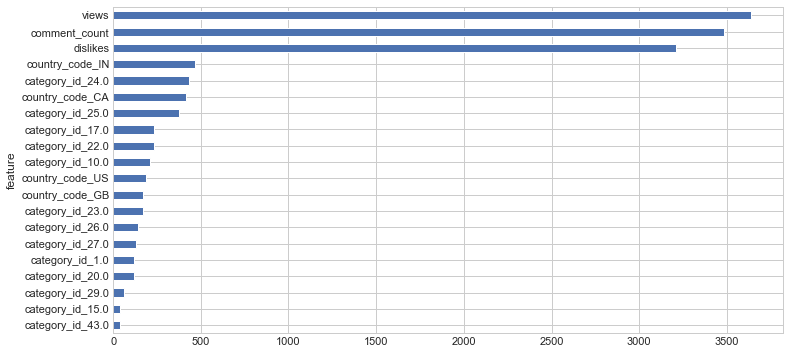

In [131]:
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds_tuned.csv')


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.723103
[600]	valid_0's rmse: 0.686531
[900]	valid_0's rmse: 0.678552
[1200]	valid_0's rmse: 0.674989
[1500]	valid_0's rmse: 0.67309
[1800]	valid_0's rmse: 0.672312
[2100]	valid_0's rmse: 0.672057
Early stopping, best iteration is:
[2018]	valid_0's rmse: 0.671998

AV metric score for validation set is 671.9983043438998

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.718972
[600]	valid_0's rmse: 0.683904
[900]	valid_0's rmse: 0.676098
[1200]	valid_0's rmse: 0.673153
[1500]	valid_0's rmse: 0.672322
[1800]	valid_0's rmse: 0.6722
Early stopping, best iteration is:
[1823]	valid_0's rmse: 0.672159

AV metric score for validation set is 672.1594296475782

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.716253
[600]	valid_0's rmse

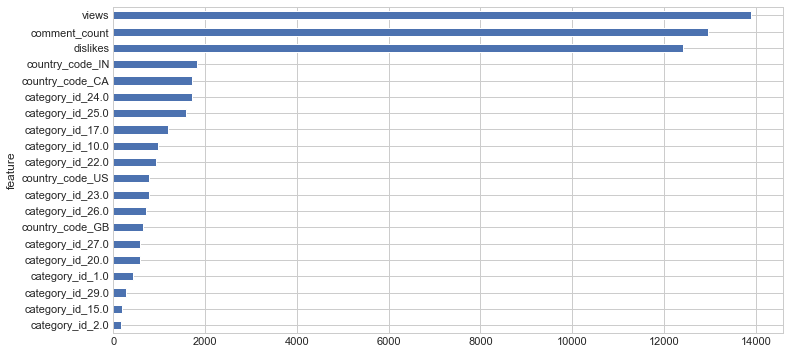

In [132]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds_tuned.csv')

Cat boost


------------- Fold 1 -------------
0:	learn: 1.9127614	test: 1.9165363	best: 1.9165363 (0)	total: 447ms	remaining: 22m 20s
200:	learn: 0.8402015	test: 0.8554455	best: 0.8554455 (200)	total: 2.79s	remaining: 38.9s
400:	learn: 0.7306103	test: 0.7478783	best: 0.7478783 (400)	total: 4.88s	remaining: 31.7s
600:	learn: 0.7054909	test: 0.7235063	best: 0.7235063 (600)	total: 7.09s	remaining: 28.3s
800:	learn: 0.6913132	test: 0.7106243	best: 0.7106243 (800)	total: 9.15s	remaining: 25.1s
1000:	learn: 0.6803178	test: 0.7009652	best: 0.7009652 (1000)	total: 11.2s	remaining: 22.3s
1200:	learn: 0.6703127	test: 0.6927000	best: 0.6927000 (1200)	total: 13.5s	remaining: 20.2s
1400:	learn: 0.6625063	test: 0.6869944	best: 0.6869944 (1400)	total: 16.4s	remaining: 18.7s
1600:	learn: 0.6562183	test: 0.6828067	best: 0.6828067 (1600)	total: 18.7s	remaining: 16.3s
1800:	learn: 0.6509194	test: 0.6794709	best: 0.6794709 (1800)	total: 21s	remaining: 14s
2000:	learn: 0.6462100	test: 0.6768118	best: 0.6768118 (2000

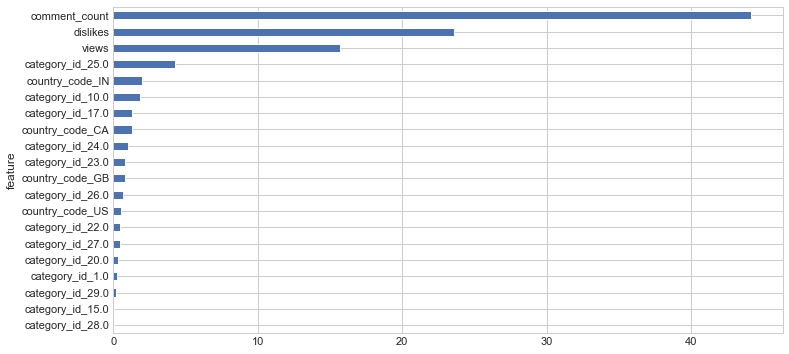

In [133]:
clf = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [134]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 'hacklive_catboostb_3folds.csv')

In [135]:
pd.read_csv('hacklive_catboostb_3folds.csv').head()

video_id        likes
0     87185   627.208361
1      9431  2223.151213
2     40599    63.185346
3       494  3520.516750
4     73942  1054.432986

XGboost


------------- Fold 1 -------------
[0]	validation_0-rmse:7.13876
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.68385
[400]	validation_0-rmse:0.67708
[600]	validation_0-rmse:0.67630
Stopping. Best iteration:
[567]	validation_0-rmse:0.67604


AV metric score for validation set is 676.0364189648351

------------- Fold 2 -------------
[0]	validation_0-rmse:7.12558
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.68982
[400]	validation_0-rmse:0.68443
[600]	validation_0-rmse:0.68445
Stopping. Best iteration:
[478]	validation_0-rmse:0.68391


AV metric score for validation set is 683.9133517904922

------------- Fold 3 -------------
[0]	validation_0-rmse:7.12518
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.68387
[400]	validation_0-rmse:0.68005
[600]	validation_0-rmse:0.67987
[800]	validation_0-rmse:0.68058
Stopping. Best iteration:
[616]	validation_0-rmse:0.

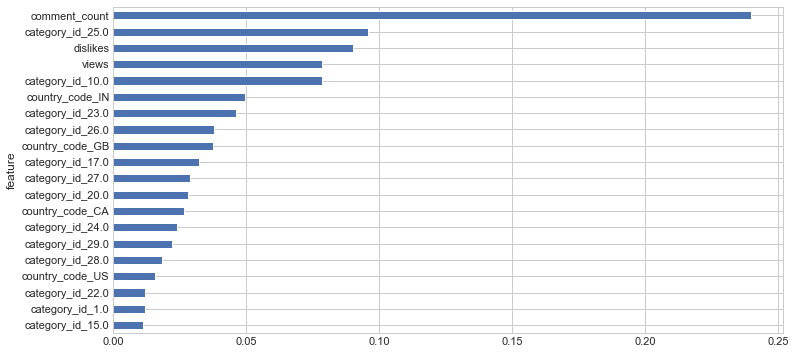

In [136]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

no improvement

## Feature Engineering
It is only used after your model is ready

In [137]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [138]:
df, features = join_df(train, test)

In [139]:
cat_cols = ['category_id', 'country_code', 'channel_title']

In [140]:
### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [141]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [142]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [143]:
cat_num_cols

['category_id',
 'channel_title',
 'comment_count',
 'country_code',
 'dislikes',
 'views',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month']

In [144]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.636734
[600]	valid_0's rmse: 0.617702
[900]	valid_0's rmse: 0.610223
[1200]	valid_0's rmse: 0.607038
[1500]	valid_0's rmse: 0.605346
[1800]	valid_0's rmse: 0.60398
[2100]	valid_0's rmse: 0.603734
Early stopping, best iteration is:
[1909]	valid_0's rmse: 0.603598

AV metric score for validation set is 603.5983105572401

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.628944
[600]	valid_0's rmse: 0.610051
[900]	valid_0's rmse: 0.60222
[1200]	valid_0's rmse: 0.59813
[1500]	valid_0's rmse: 0.595953
[1800]	valid_0's rmse: 0.594516
[2100]	valid_0's rmse: 0.593688
Early stopping, best iteration is:
[2098]	valid_0's rmse: 0.593627

AV metric score for validation set is 593.6272400837473

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rms

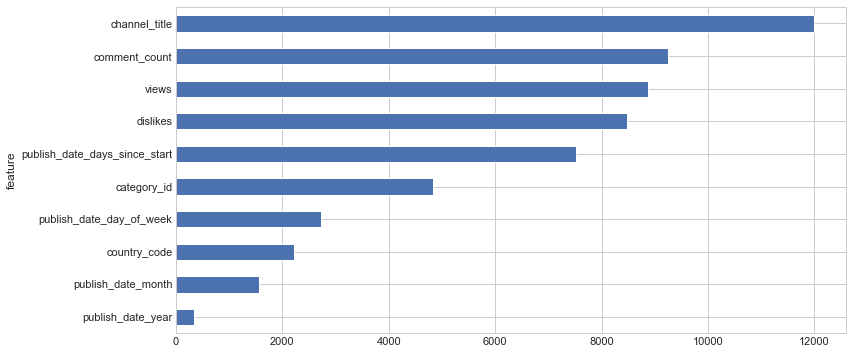

In [145]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [146]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_featureExtraction.csv')

In [147]:
pd.read_csv('hacklive_lgb_featureExtraction.csv').head()

video_id        likes
0     87185   542.675878
1      9431  1906.964250
2     40599    36.402021
3       494  3302.947433
4     73942   861.225927

In [148]:
df['channel_title'].nunique()

6979

As it contains so many unique values we go for Frequency fetaure extraction technique

In [149]:
df['channel_title'].value_counts()

116     233
299     180
15      179
92      169
406     152
       ... 
3832      1
5883      1
5551      1
1453      1
4078      1
Name: channel_title, Length: 6979, dtype: int64

In [151]:
df['publish_date'].value_counts()

2018-01-29    282
2017-12-13    258
2018-01-19    257
2017-12-20    255
2018-01-12    255
             ... 
2017-10-27      1
2013-10-27      1
2015-03-29      1
2011-02-03      1
2013-03-20      1
Name: publish_date, Length: 399, dtype: int64

In [152]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())

In [153]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [154]:
cat_num_cols

['category_id',
 'channel_title',
 'comment_count',
 'country_code',
 'dislikes',
 'views',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'publish_date_num_videos']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.615492
[600]	valid_0's rmse: 0.590787
[900]	valid_0's rmse: 0.580059
[1200]	valid_0's rmse: 0.575276
[1500]	valid_0's rmse: 0.571113
[1800]	valid_0's rmse: 0.568437
[2100]	valid_0's rmse: 0.567836
[2400]	valid_0's rmse: 0.56734
Early stopping, best iteration is:
[2332]	valid_0's rmse: 0.567211

AV metric score for validation set is 567.2107814723863

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.609558
[600]	valid_0's rmse: 0.587213
[900]	valid_0's rmse: 0.579122
[1200]	valid_0's rmse: 0.572775
[1500]	valid_0's rmse: 0.569841
[1800]	valid_0's rmse: 0.568174
[2100]	valid_0's rmse: 0.567315
[2400]	valid_0's rmse: 0.566515
Early stopping, best iteration is:
[2445]	valid_0's rmse: 0.56628

AV metric score for validation set is 566.2797219134341

------------- Fold 3 -------------
Training until v

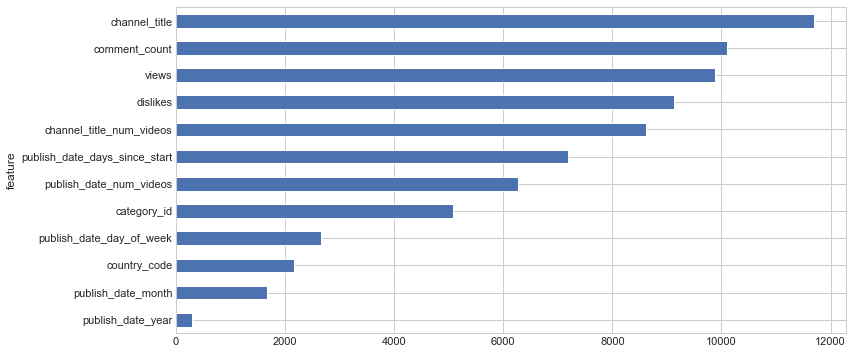

In [155]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [156]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_featureExtraction_num_videos.csv')

In [157]:
pd.read_csv('hacklive_lgb_featureExtraction_num_videos.csv').head()

video_id        likes
0     87185   661.909262
1      9431  1841.531512
2     40599    31.047059
3       494  4292.171073
4     73942   804.197131

In [158]:
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

In [159]:
df['channel_in_n_countries'].unique()

array([2, 1, 3, 4], dtype=int64)

In [160]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [161]:
# SImilarly run the LGB
#clf = LGBMRegressor(n_estimators = 5000,
#                        learning_rate = 0.05,
#                        colsample_bytree = 0.65,
#                        metric = 'None',
#                        )
#fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}
#
#lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)


In [162]:
df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

df['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')

In [163]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [164]:
cat_num_cols

['category_id',
 'channel_title',
 'comment_count',
 'country_code',
 'dislikes',
 'views',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'publish_date_num_videos',
 'channel_in_n_countries',
 'channel_title_mean_views',
 'channel_title_max_views',
 'channel_title_min_views',
 'channel_title_mean_comments',
 'channel_title_max_comments',
 'channel_title_min_comments',
 'channel_title_mean_dislikes',
 'channel_title_max_dislikes',
 'channel_title_min_dislikes']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.556851
[600]	valid_0's rmse: 0.529839
[900]	valid_0's rmse: 0.519028
[1200]	valid_0's rmse: 0.514678
[1500]	valid_0's rmse: 0.512969
[1800]	valid_0's rmse: 0.511477
[2100]	valid_0's rmse: 0.510455
[2400]	valid_0's rmse: 0.510058
[2700]	valid_0's rmse: 0.509852
Early stopping, best iteration is:
[2667]	valid_0's rmse: 0.509804

AV metric score for validation set is 509.804193603581

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.54115
[600]	valid_0's rmse: 0.519223
[900]	valid_0's rmse: 0.510475
[1200]	valid_0's rmse: 0.50604
[1500]	valid_0's rmse: 0.503284
[1800]	valid_0's rmse: 0.50267
[2100]	valid_0's rmse: 0.501842
[2400]	valid_0's rmse: 0.501573
[2700]	valid_0's rmse: 0.501155
[3000]	valid_0's rmse: 0.500959
[3300]	valid_0's rmse: 0.500802
Early stopping, best iteration is:
[3344]	valid_0'

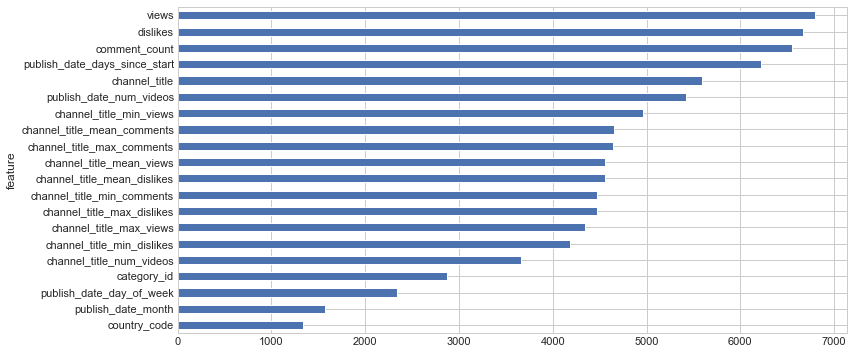

In [165]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [166]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_featureExtraction_num_videos.csv')

In [167]:
pd.read_csv('hacklive_lgb_featureExtraction_num_videos.csv').head()

video_id        likes
0     87185   653.887228
1      9431  2056.963802
2     40599    35.501164
3       494  3718.937511
4     73942   544.535150

## Feature Engineering of Text data

In [189]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [190]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [191]:
cat_num_cols

['category_id',
 'channel_title',
 'comment_count',
 'country_code',
 'dislikes',
 'views',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'publish_date_num_videos',
 'channel_in_n_countries',
 'channel_title_mean_views',
 'channel_title_max_views',
 'channel_title_min_views',
 'channel_title_mean_comments',
 'channel_title_max_comments',
 'channel_title_min_comments',
 'channel_title_mean_dislikes',
 'channel_title_max_dislikes',
 'channel_title_min_dislikes',
 'title_len',
 'description_len',
 'tags_len']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.547788
[600]	valid_0's rmse: 0.524121
[900]	valid_0's rmse: 0.513338
[1200]	valid_0's rmse: 0.508415
[1500]	valid_0's rmse: 0.505962
[1800]	valid_0's rmse: 0.505197
[2100]	valid_0's rmse: 0.504648
[2400]	valid_0's rmse: 0.504063
[2700]	valid_0's rmse: 0.503593
[3000]	valid_0's rmse: 0.503464
[3300]	valid_0's rmse: 0.502986
[3600]	valid_0's rmse: 0.502729
[3900]	valid_0's rmse: 0.502534
[4200]	valid_0's rmse: 0.502326
Early stopping, best iteration is:
[4107]	valid_0's rmse: 0.502271

AV metric score for validation set is 502.2708102114354

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.532739
[600]	valid_0's rmse: 0.508669
[900]	valid_0's rmse: 0.500341
[1200]	valid_0's rmse: 0.495703
[1500]	valid_0's rmse: 0.493165
[1800]	valid_0's rmse: 0.491479
[2100]	valid_0's rmse: 0.490391
[2400]	valid_0

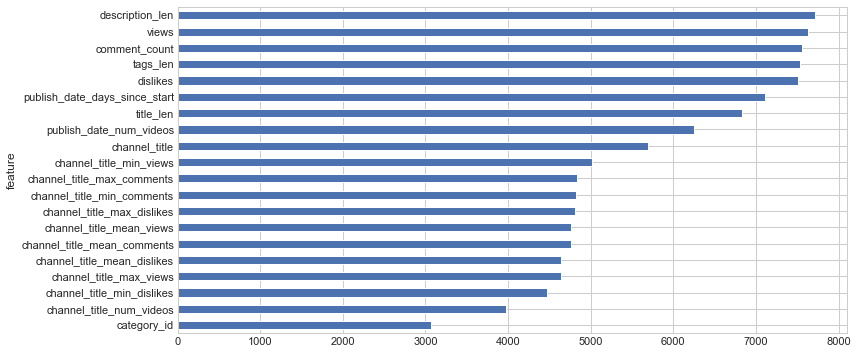

In [192]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [174]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_text_cols_len.csv')

In [175]:
pd.read_csv('hacklive_lgb_text_cols_len.csv').head()

video_id        likes
0     87185   667.519809
1      9431  2404.044983
2     40599    50.651152
3       494  3452.263156
4     73942   579.834855

In [184]:
fi

feature
category_id                      3067.000000
channel_title_num_videos         3971.333333
channel_title_min_dislikes       4474.000000
channel_title_max_views          4643.000000
channel_title_mean_dislikes      4644.000000
channel_title_mean_comments      4756.000000
channel_title_mean_views         4756.333333
channel_title_max_dislikes       4807.333333
channel_title_min_comments       4825.666667
channel_title_max_comments       4836.666667
channel_title_min_views          5019.333333
channel_title                    5699.000000
publish_date_num_videos          6250.333333
title_len                        6827.666667
publish_date_days_since_start    7109.000000
dislikes                         7505.000000
tags_len                         7535.666667
comment_count                    7551.000000
views                            7634.666667
description_len                  7717.666667
Name: importance, dtype: float64

In [185]:
to_drop_cols = ['views']

In [186]:
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date'] + to_drop_cols]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.596467
[600]	valid_0's rmse: 0.576642
[900]	valid_0's rmse: 0.567259
[1200]	valid_0's rmse: 0.562057
[1500]	valid_0's rmse: 0.559601
[1800]	valid_0's rmse: 0.558393
[2100]	valid_0's rmse: 0.557246
[2400]	valid_0's rmse: 0.556856
[2700]	valid_0's rmse: 0.556535
[3000]	valid_0's rmse: 0.556255
Early stopping, best iteration is:
[2978]	valid_0's rmse: 0.556216

AV metric score for validation set is 556.2159524054288

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.580555
[600]	valid_0's rmse: 0.560259
[900]	valid_0's rmse: 0.551665
[1200]	valid_0's rmse: 0.548444
[1500]	valid_0's rmse: 0.54619
[1800]	valid_0's rmse: 0.545049
[2100]	valid_0's rmse: 0.544577
[2400]	valid_0's rmse: 0.544171
Early stopping, best iteration is:
[2361]	valid_0's rmse: 0.544056

AV metric score for validation set is 544.0

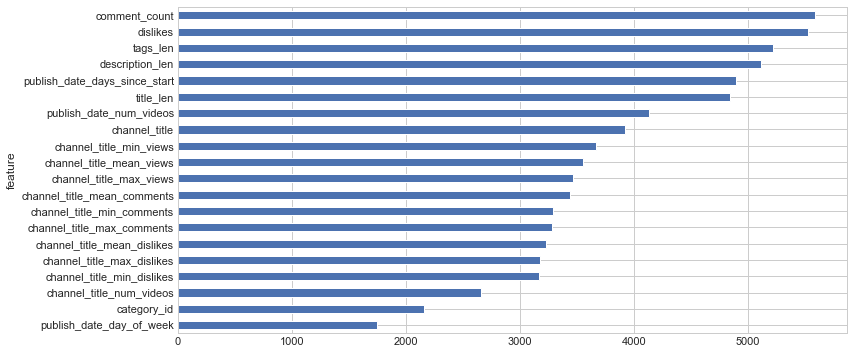

In [187]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

## Ensembling technique
the outputs of all the above models produces meta features that will be used as an input to one above layer model to give better predictive performance

In [193]:
 av_metric(np.log1p(train[TARGET_COL]), lgb_oofs * 0.95 + cb_oofs * 0.05)

494.9239221848432

In [194]:
train_new = train[[ID_COL, TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [195]:
clf = LinearRegression()

ens_oofs, ens_preds = run_clf_kfold(clf, train_new, test_new, features)


------------- Fold 1 -------------

AV metric score for validation set is 502.1618465275399

------------- Fold 2 -------------

AV metric score for validation set is 488.20706696910565

------------- Fold 3 -------------

AV metric score for validation set is 493.92997515204274


AV metric for oofs is 494.8001837079266


In [198]:
ens_preds_t = np.expm1(ens_preds)
download_preds(ens_preds_t, file_name = 'hacklive_ensemble_final.csv')

In [199]:
pd.read_csv('hacklive_ensemble_final.csv').head()

video_id        likes
0     87185   665.638315
1      9431  2406.032198
2     40599    49.597922
3       494  3390.714436
4     73942   603.224269